In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../')
import picea
picea.__version__,picea

('0.0.3_beta1', <module 'picea' from '../picea/__init__.py'>)

In [2]:
from picea import Tree

In [15]:
tree = Tree.from_newick(filename='./data/tree.newick')
print(tree.to_json(indent=2))

{
  "ID": 0,
  "name": "",
  "length": 0.0,
  "children": [
    {
      "ID": 1,
      "name": "Eucgr.J03126.1",
      "length": 0.096360892,
      "children": []
    },
    {
      "ID": 2,
      "name": "1.000",
      "length": 0.159121648,
      "children": [
        {
          "ID": 3,
          "name": "Eucgr.F03978.1",
          "length": 0.022217443,
          "children": []
        },
        {
          "ID": 4,
          "name": "0.989",
          "length": 0.033587992,
          "children": [
            {
              "ID": 5,
              "name": "Eucgr.F03972.1",
              "length": 0.049020651,
              "children": []
            },
            {
              "ID": 6,
              "name": "0.992",
              "length": 0.028383846,
              "children": [
                {
                  "ID": 7,
                  "name": "Eucgr.F03974.1",
                  "length": 0.016885197,
                  "children": []
                },
                {

In [1]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],
              [4, 2], [4, 4], [4, 0]])
clustering = AgglomerativeClustering().fit(X)
clustering.labels_


array([1, 1, 1, 0, 0, 0])

In [45]:
import re
from typing import Iterable, Callable, List


def unequal_separation(
    node_a: 'Tree',
    node_b: 'Tree',
    sep_1: float = 1.0,
    sep_2: float = 2.0
) -> float:
    """[summary]

    Args:
        node_a (Tree): [description]
        node_b (Tree): [description]
        sep_1 (float, optional): [description]. Defaults to 1.0.
        sep_2 (float, optional): [description]. Defaults to 2.0.

    Returns:
        float: [description]
    """
    if node_a.parent == node_b.parent:
        return sep_1
    return sep_2


def equal_separation(
    node_a: 'Tree',
    node_b: 'Tree',
    separation: float = 1.0
) -> float:
    """[summary]

    Args:
        node_a (Tree): [description]
        node_b (Tree): [description]
        separation (float, optional): [description]. Defaults to 1.0.

    Returns:
        float: [description]
    """
    return separation


def index_equals(
    node: 'Tree',
    index: int
) -> bool:
    """[summary]

    Args:
        node (Tree): [description]
        index (int): [description]

    Returns:
        bool: [description]
    """
    return node.ID == index


def name_equals(
    node: 'Tree',
    name: str
) -> bool:
    """[summary]

    Args:
        node (Tree): [description]
        name (str): [description]

    Returns:
        bool: [description]
    """
    return node.name == name


class Tree:
    def __init__(
        self,
        ID: int = None,
        children: List['Tree'] = None,
        x: float = 0.0,
        y: float = 0.0,
        name: str = '',
        length: float = 0.0,
        depth: float = None,
        parent: 'Tree' = None,
        cumulative_length: float = 0.0
    ):
        """Recursive datastructure holding tree objects

        Args:
            ID (int, optional): [description]. Defaults to None.
            children (list, optional): [description]. Defaults to None.
            x (float, optional): [description]. Defaults to 0.0.
            y (float, optional): [description]. Defaults to 0.0.
            name (str, optional): [description]. Defaults to ''.
            length (float, optional): [description]. Defaults to 0.
            depth (float, optional): [description]. Defaults to None.
            parent (Tree, optional): [description]. Defaults to None.
            cumulative_length (int, optional): [description]. Defaults to 0.
        """
        if not children:
            children = list()
        self.ID = ID
        self.children = children
        self.x = x
        self.y = y
        self.name = name
        self.depth = depth
        self.parent = parent
        self.length = length
        self.cumulative_length = cumulative_length

    def __repr__(self):
        return (
            f'<TreeNode ID={self.ID} depth={self.depth}'
            f' length={self.length} name={self.name}>'
        )

    @property
    def loc(self):
        """Name based index

        Example:
            >>> from picea import Tree
            >>> newick = '(((a,b),(c,d)),e);'
            >>> tree = Tree.from_newick(newick)
            >>> tree.loc['a']
            <TreeNode ID=3 depth=3 length=0.0 name=a>

        Returns:
            Tree: tree node matching name

        Raises:
            IndexError
        """
        return TreeIndex(iterator=self.depth_first, eq_func=name_equals)

    @property
    def iloc(self):
        """Index based index

        Example:
            >>> from picea import Tree
            >>> newick = '(((a,b),(c,d)),e);'
            >>> tree = Tree.from_newick(newick)
            >>> tree.iloc[1]
            <TreeNode ID=1 depth=1 length=0.0 name=>

        Returns:
            Tree: tree node matching index
        """
        return TreeIndex(iterator=self.depth_first, eq_func=index_equals)

    @property
    def nodes(self):
        """A list of all tree nodes in breadth-first order

        Returns:
            list: A list of all tree nodes
        """
        return list(self.breadth_first())

    @property
    def leaves(self):
        """A list of leaf nodes only

        Returns:
            list: A list of leaf nodes only
        """
        return [n for n in self.nodes if not n.children]

    @property
    def links(self):
        """A list of all (parent, child) combinations

        Returns:
            list: All (parent,child) combinations
        """
        _links = []
        for node in self.nodes:
            if node.children:
                for child in node.children:
                    _links.append((node, child))
        return _links

    @classmethod
    def from_newick(
        cls,
        newick_string: str
    ):
        """Parse a newick formatted string into a Tree object

        Arguments:
            newick_string (string): Newick formatted tree string

        Returns:
            Tree: Tree object
        """
        tokens = re.split(r'\s*(;|\(|\)|,|:)\s*', newick_string)
        ID = 0
        tree = cls(ID=ID, length=0.0, cumulative_length=0.0)
        ancestors = list()
        for i, token in enumerate(tokens):
            if token == '(':
                ID += 1
                subtree = cls(ID=ID)
                tree.children = [subtree]
                ancestors.append(tree)
                tree = subtree
            elif token == ',':
                ID += 1
                subtree = cls(ID=ID)
                ancestors[-1].children.append(subtree)
                tree = subtree
            elif token == ')':
                tree = ancestors.pop()
            else:
                previous_token = tokens[i - 1]
                if previous_token in ('(', ')', ','):
                    tree.name = token
                elif previous_token == ':':
                    tree.length = float(token)
        tree.depth = 0
        queue = [tree]
        while queue:
            node = queue.pop(0)
            for child in node.children:
                child.parent = node
                child.depth = node.depth + 1
                child.cumulative_length = node.cumulative_length \
                    + abs(child.length)
            queue += node.children

        return tree

    def to_newick(
        self,
        branch_lengths: bool = True
    ):
        """Make a Newick formatted string

        Args:
            branch_lengths (bool, optional): Whether to include branch lengths\
             in the Newick string. Defaults to True.

        Returns:
            String: Newick formatted tree string
        """
        if self.children:
            subtree_string = ','.join([
                c.to_newick(branch_lengths=branch_lengths)
                for c in self.children
            ])
            newick = f'({subtree_string}){self.name}'
        else:
            newick = str(self.name)

        if branch_lengths and self.ID != 0:
            length = self.length
            if length == 0:
                length = int(0)
            newick += f':{length}'

        if self.ID == 0:
            newick += ';'

        return newick
    
    @classmethod
    def from_sklearn(
        cls,
        clustering
    ):
        """[summary]
        
        Args:
            clustering ([type]): [description]
        """
        nodes = clustering.children_
        n_leaves = nodes.shape[0] + 1
        tree = cls(ID=nodes.shape[0] * 2)

        queue = [tree]
        while queue:
            node = queue.pop(0)
            if node.ID < n_leaves:
                node.name = str(node.ID)
                continue
            for child_ID in nodes[node.ID - n_leaves]:
                child = cls(ID=child_ID)
                child.parent = node
                node.children.append(child)
            queue += node.children

        return tree

    def breadth_first(self):
        """Generator implementing breadth first search starting at root node
        """
        queue = [self]
        while queue:
            node = queue.pop(0)
            queue += node.children
            yield node

    def depth_first(
        self,
        post_order: bool = True
    ):
        """Generator implementing depth first search in either post- or
        pre-order traversel

        Keyword Arguments:
            post_order (bool, optional): Depth first search in post-order
            traversal or not. Defaults to True
        """
        if not post_order:
            yield self
        for child in self.children:
            yield from child.depth_first(post_order=post_order)
        if post_order:
            yield self

    def layout(
        self,
        separation: Callable = equal_separation,
        d_x: float = 1.0,
        d_y: float = 1.0,
        ltr: bool = True
    ):
        """Calculate (x,y) position of nodes for plotting,
        modifies nodes in place

        Args:
            separation (function, optional): function to calculate separation \
            between leaf nodes. Defaults to equal_separation.
            d_x (int, optional): x-axis distance between neighbouring nodes. \
            Defaults to 1.
            d_y (int, optional): y-axis distance between neighbouring nodes.
            Defaults to 1.
            ltr (bool, optional): Left-To-Right layout orientation. Defaults
            to True.

        Returns:
            Tree: Original root node with modified (x,y) coordinates according
            to specified layout properties
        """
        previous_node = None
        y = 0
        for node in self.depth_first(post_order=True):
            if node.children:
                node.y = sum([c.y for c in node.children]) / len(node.children)
                if ltr:
                    node.x = 1 + max([c.x for c in node.children])
                else:
                    node.x = min([c.x for c in node.children]) - 1
            else:
                if previous_node:
                    y += separation(node, previous_node)
                    node.y = y
                else:
                    node.y = 0
                node.x = 0
                previous_node = node

        for node in self.depth_first(post_order=True):
            node.x = (self.x - node.x) * d_x
            node.y = (node.y - self.y) * d_y
        return self


class TreeIndex(object):
    def __init__(
        self,
        iterator: Iterable[Tree],
        eq_func: Callable[[int, str], bool]
    ):
        """[summary]

        Args:
            object ([type]): [description]
            iterator ([type]): [description]
            eq_func ([type]): [description]
        """
        self.iterator = iterator
        self.eq_func = eq_func

    def __getitem__(self, key):
        for element in self.iterator():
            if self.eq_func(element, key):
                return element
        raise IndexError(f'{key} is not valid index')


In [46]:
tree = Tree.from_sklearn(clustering)
tree.to_newick(branch_lengths=False)

'((2,(0;,1)),(4,(3,5)))'

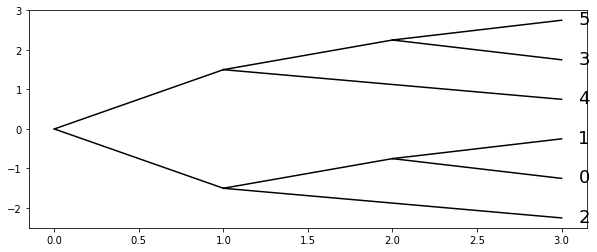

In [42]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize = (10, 4))

#left-to-right layout with direct links
tree.layout(ltr = True)
for node1, node2 in tree.links:
    ax.plot(
        (node1.x, node2.x),
        (node1.y, node2.y),
        c = 'k'
    )
for leaf in tree.leaves:
    ax.text(
        leaf.x + .1, 
        leaf.y - .1, 
        leaf.name,
        fontsize = 18
    )
ax1

In [21]:
nodes = clustering.children_
n_leaves = nodes.shape[0] + 1
tree = cls(ID=nodes.shape[0] * 2)

queue = [tree]
while queue:
    node = queue.pop(0)
    if node.ID < n_leaves:
        continue
    for child_ID in nodes[node.ID - n_leaves]:
        child = cls(ID=child_ID)
        child.parent = node
        node.children.append(child)
    queue += node.children

return tree
    


(10, 8, 9)